# HOW MUCH BENTHIC HABITAT HAS BEEN LOST?

#### 1) If we use an aragonite threshold to define suitable benthic habitat, how much benthic habitat was lost from preindustrial to present-day?

#### 1b) how much of benthic habitat shallower than 50m was lost?



In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
from __future__ import print_function
from numpy import *
from scipy import *
import matplotlib.pyplot as plt
import pickle

import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy as sp
import warnings
warnings.filterwarnings('ignore')

import seawater
import datetime as dt
""
from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-whitegrid')
import netCDF4 as nc

import cmocean as cm
import glob
import sys
sys.path.append('/data/tjarniko/mocsy')
sys.path.append('/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/CCCmaDEV/CCCma_src')
import mocsy
import CCCma
import CCCma_stations as cs
from matplotlib import reload
import arrow
import gsw
%matplotlib inline

import xarray as xr
from datetime import datetime
from salishsea_tools import grid_tools, viz_tools

from math import log10, floor


### A map of the bathymetry of the Salish Sea

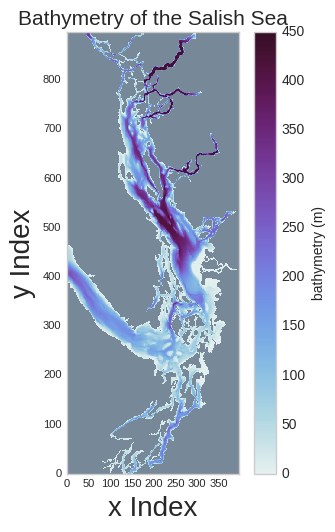

In [4]:
bath = nc.Dataset('/data/tjarniko/MEOPAR/grid/bathymetry_201702.nc')
bath1 = bath.variables['Bathymetry']

def plot_bathy(surfdat_1,tit1,t_cmap,xsize,ysize,v_min1,v_max1,cl1,bigtit):

    fig, ax = plt.subplots(1, 1, figsize=(xsize, ysize), sharey=True)
    cmap = t_cmap

    tplt = np.ma.masked_values(surfdat_1,0)
    ax.set_title(tit1,fontsize = 15 )
    v_min = v_min1
    v_max = v_max1
    clabel = cl1

    viz_tools.set_aspect(ax)
    mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=v_min, vmax=v_max) 
    ax.set_xlabel('x Index', fontsize = 20 )
    ax.set_ylabel('y Index', fontsize = 20 )

    plt.xlim([0,398])
    plt.ylim([0,898])
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    cmap.set_bad('lightslategray')
    plt.suptitle(bigtit,fontsize=20)
    cbar = plt.colorbar(mesh)
    cbar.set_label(clabel)
fact = 0.19
plot_bathy(bath1,'Bathymetry of the Salish Sea', \
               cm.cm.dense,20*fact,30*fact,0,450,'bathymetry (m)','')

### A map of the bathymetry of the Salish Sea, showing where water is shallower than 50m

428.0
4.0


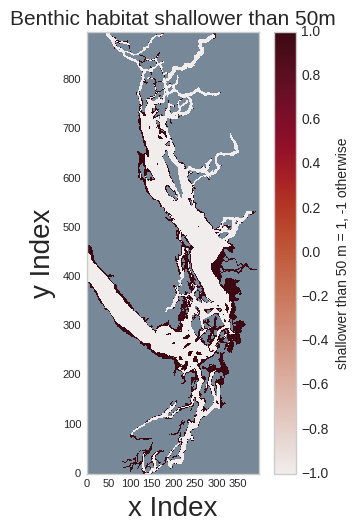

In [5]:
bath = nc.Dataset('/data/tjarniko/MEOPAR/grid/bathymetry_201702.nc')
bath1 = bath.variables['Bathymetry']

def plot_bathythres(surfdat_1,tit1,t_cmap,xsize,ysize,v_min1,v_max1,cl1,bigtit, thres):

    fig, ax = plt.subplots(1, 1, figsize=(xsize, ysize), sharey=True)
    cmap = t_cmap

    tplt = np.ma.masked_values(surfdat_1,0)
    print(np.max(tplt))
    print(np.min(tplt))
    tplt2 = np.zeros_like(tplt)
    w = np.where(tplt>50)
    w2 = np.where(tplt<50)
    tplt[w] = -1
    tplt2[w2] =1

    
    ax.set_title(tit1,fontsize = 15 )
    v_min = v_min1
    v_max = v_max1
    clabel = cl1

    viz_tools.set_aspect(ax)
    mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=v_min, vmax=v_max) 
    ax.set_xlabel('x Index', fontsize = 20 )
    ax.set_ylabel('y Index', fontsize = 20 )

    plt.xlim([0,398])
    plt.ylim([0,898])
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    cmap.set_bad('lightslategray')
    plt.suptitle(bigtit,fontsize=20)
    cbar = plt.colorbar(mesh)
    cbar.set_label(clabel)
fact = 0.19
plot_bathythres(bath1,'Benthic habitat shallower than 50m', \
               cm.cm.amp,20*fact,30*fact,-1,1,'shallower than 50 m = 1, -1 otherwise','',50)

## What does asat look like at 4 m at one day - Apr 1, 2015? Assuming inhabitable habitat is > 1.5 OmegaA, What percentage has been lost?

In [6]:
rootdir = '/data/tjarniko/results/BASERUN_EXP/MAIN/'

TS_BR = glob.glob(rootdir + 'BR_2nd_2015/ncs/' + '*grid_T_20150401-20150401.nc')
nc_TS_BR = nc.Dataset(TS_BR[0])
C_BR = glob.glob(rootdir + 'BR_2nd_2015/ncs/' + '*carp_T_20150401-20150401.nc')
nc_C_BR = nc.Dataset(C_BR[0])


TS_PI = glob.glob(rootdir + 'PI_ACBC_2015_3/ncs/' + '*grid_T_20150401-20150401.nc')
nc_TS_PI = nc.Dataset(TS_PI[0])
C_PI = glob.glob(rootdir + 'PI_ACBC_2015_3/ncs/' + '*carp_T_20150401-20150401.nc')
nc_C_PI = nc.Dataset(C_PI[0])


In [7]:
tsal = nc_TS_PI['vosaline'][0,0,:,:]
ttemp =  nc_TS_PI['votemper'][0,0,:,:]
tdic = nc_C_PI['dissolved_inorganic_carbon'][0,0,:,:]
tta = nc_C_PI['total_alkalinity'][0,0,:,:]

In [8]:
def mocsy_2d_getOmA(tsal,ttemp,tdic,tta):
    tsra = np.ravel(tsal)
    ttera = np.ravel(ttemp)
    ttara = np.ravel(tta) * 1e-3
    tdra = np.ravel(tdic) * 1e-3
    tzero = np.zeros_like(tsra)
    tpressure = np.zeros_like(tsra)
    tpressure[:] =1
    tzero = tpressure * 0 

    tsra_psu = tsra*35/35.16504
    ttera_is = gsw.t_from_CT(tsra,ttera,tzero)

    response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                       sil=tzero, phos=tzero, patm=tpressure, depth=tzero, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup


    OmegaAR = OmegaA.reshape(898,398)
    return OmegaAR

In [9]:
tsal = nc_TS_PI['vosaline'][0,0,:,:]
ttemp =  nc_TS_PI['votemper'][0,0,:,:]
tdic = nc_C_PI['dissolved_inorganic_carbon'][0,0,:,:]
tta = nc_C_PI['total_alkalinity'][0,0,:,:]

OmA_PI = mocsy_2d_getOmA(tsal,ttemp,tdic,tta)

tsal = nc_TS_BR['vosaline'][0,0,:,:]
ttemp =  nc_TS_BR['votemper'][0,0,:,:]
tdic = nc_C_BR['dissolved_inorganic_carbon'][0,0,:,:]
tta = nc_C_BR['total_alkalinity'][0,0,:,:]

OmA_BR = mocsy_2d_getOmA(tsal,ttemp,tdic,tta)

    ## PRACTICE PLOT

3.463266636393224
0.0
2.9554318484364597
0.0


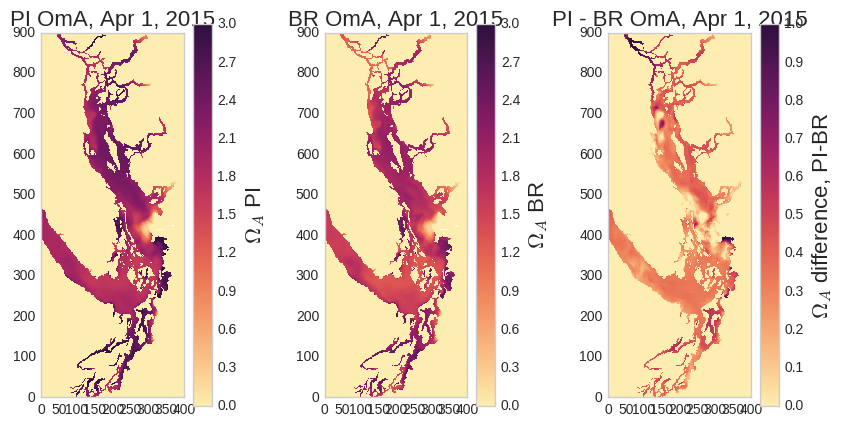

In [10]:
fact = 0.7
tf = 16
tcmap = cm.cm.matter
j_s = 800
j_e = 898
i_s = 300
i_e = 398
fig = plt.figure(figsize=(12*fact,6.5*fact))

ax1 = fig.add_subplot(1,3,1)
tplt = np.ma.masked_values(OmA_PI,0)
OmA_PI2 = np.copy(OmA_PI)
OmA_PI2[OmA_PI2 > 1e10] = 0
print(np.max(OmA_PI2))
print(np.min(OmA_PI2))
viz_tools.set_aspect(ax1)
tplt[tplt>1e10] = np.nan
mesh = ax1.pcolormesh(tplt, cmap=tcmap, vmin=0, vmax=3)
#viz_tools.plot_land_mask(ax1, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'lightslategrey')
ax1.set_title('PI OmA, Apr 1, 2015', fontsize = tf)
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$ PI', fontsize = tf)


ax2 = fig.add_subplot(1,3,2)
tplt = np.ma.masked_values(OmA_BR,0)
tplt[tplt>1e10] = np.nan
OmA_BR2 = np.copy(OmA_BR)
OmA_BR2[OmA_BR2 > 1e10] = 0
print(np.max(OmA_BR2))
print(np.min(OmA_BR2))
viz_tools.set_aspect(ax2)
mesh = ax2.pcolormesh(tplt, cmap=tcmap, vmin=0, vmax=3)
ax2.set_title('BR OmA, Apr 1, 2015', fontsize = tf)
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$ BR', fontsize = tf)

ax3 = fig.add_subplot(1,3,3)
tplt = np.ma.masked_values(OmA_PI,0) - np.ma.masked_values(OmA_BR,0)
tplt = OmA_PI - OmA_BR
viz_tools.set_aspect(ax3)
tplt[tplt>1e10] = np.nan
mesh = ax3.pcolormesh(tplt, cmap=tcmap, vmin=0, vmax=1)
ax3.set_title('PI - BR OmA, Apr 1, 2015', fontsize = tf)

cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$ difference, PI-BR', fontsize = tf)

plt.tight_layout()

In [11]:

thres = 1.5
print('Omega A threshold for habitable cell is '+str(thres))

Omega A threshold for habitable cell is 1.5


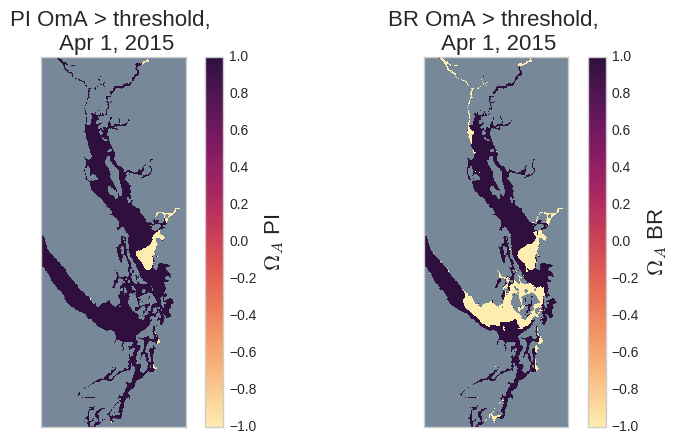

In [12]:
fact = 0.7
tf = 16
tcmap = cm.cm.matter
fig = plt.figure(figsize=(12*fact,6.5*fact))

ax1 = fig.add_subplot(1,2,1)
tplt = np.ma.masked_values(OmA_PI,0)
OmA_PI2 = np.copy(tplt)
OmA_PI2[OmA_PI2 > 1e10] = 0
w = np.where(tplt>=thres)
w2 = np.where(tplt<thres)
OmA_PI2[w] = 1
OmA_PI2[w2] = -1
viz_tools.set_aspect(ax1)
mesh = ax1.pcolormesh(OmA_PI2, cmap=tcmap, vmin=-1, vmax=1)

viz_tools.plot_land_mask(ax1, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'lightslategrey')
ax1.set_title('PI OmA > threshold, \n Apr 1, 2015', fontsize = tf)
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$ PI', fontsize = tf)
plt.xticks([])
plt.yticks([])

ax2 = fig.add_subplot(1,2,2)
tplt = np.ma.masked_values(OmA_BR,0)
OmA_BR2 = np.copy(tplt)
OmA_BR2[OmA_BR2 > 1e10] = 0
w = np.where(tplt>=thres)
w2 = np.where(tplt<thres)
OmA_BR2[w] = 1
OmA_BR2[w2] = -1
viz_tools.set_aspect(ax2)
mesh = ax2.pcolormesh(OmA_BR2, cmap=tcmap, vmin=-1, vmax=1)

viz_tools.plot_land_mask(ax2, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'lightslategrey')
ax2.set_title('BR OmA > threshold, \n Apr 1, 2015', fontsize = tf)
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$ BR', fontsize = tf)
plt.xticks([])
plt.yticks([])


plt.tight_layout()

In [13]:
print('OmA threshold for habitability: '+str(thres))
OmA_PI3 = np.zeros_like(OmA_PI2)
w = np.where(OmA_PI2==1)
OmA_PI3[w] = 1
print('grid cells habitable at 4 m (PI): ' + str(int(np.sum(OmA_PI3))))
OmA_BR3 = np.zeros_like(OmA_BR2)
w = np.where(OmA_BR2==1)
OmA_BR3[w] = 1
print('grid cells habitable at 4 m (BR): ' + str(int(np.sum(OmA_BR3))))
print('cells lost, percentage: '+ \
      str(100*(np.sum(OmA_PI3)-np.sum(OmA_BR3))/np.sum(OmA_PI3)))

OmA threshold for habitability: 1.5
grid cells habitable at 4 m (PI): 352434
grid cells habitable at 4 m (BR): 334557
cells lost, percentage: 5.072439094979486


## Benthic $\Omega_A$ and suitable habitat, $\Omega_A$ threshold = 1

In [14]:
thres = 1.0

In [16]:
f = open('./new_pickle/PI_OmA_apr_benthos_mbath.pkl', 'rb')
PI_OmA_apr_benthos = pickle.load(f)   
f = open('./new_pickle/BR_OmA_apr_benthos_mbath.pkl', 'rb')
BR_OmA_apr_benthos = pickle.load(f)  

f = open('./new_pickle/PI_OmA_aug_benthos_mbath.pkl', 'rb')
PI_OmA_aug_benthos = pickle.load(f)  
f = open('./new_pickle/BR_OmA_aug_benthos_mbath.pkl', 'rb')
BR_OmA_aug_benthos = pickle.load(f)  

f = open('./new_pickle/PI_OmA_dec_benthos_mbath.pkl', 'rb')
PI_OmA_dec_benthos = pickle.load(f)
f = open('./new_pickle/BR_OmA_dec_benthos_mbath.pkl', 'rb')
BR_OmA_dec_benthos = pickle.load(f)

([], <a list of 0 Text yticklabel objects>)

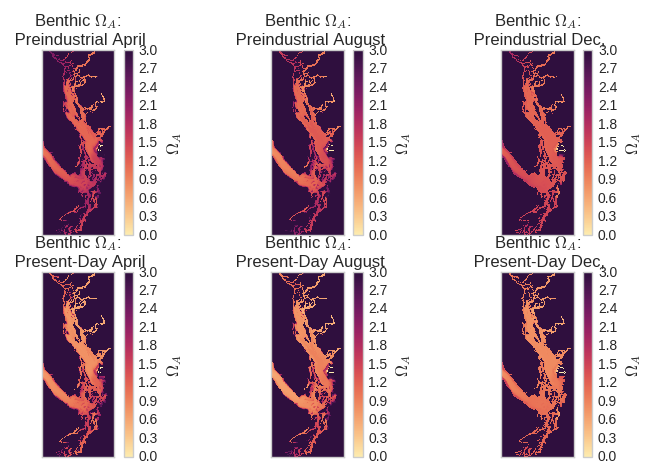

In [17]:
fact = 0.7
tf = 12
tcmap = cm.cm.matter
tvmin = 0
tvmax = 3

fig = plt.figure(figsize=(12*fact,7.5*fact))

ax = fig.add_subplot(2,3,1)
tplt = np.ma.masked_values(PI_OmA_apr_benthos,0)
mesh = ax.pcolormesh(tplt, cmap=tcmap, vmin=tvmin, vmax=tvmax)
viz_tools.set_aspect(ax)
#viz_tools.plot_land_mask(ax, \
#                         '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'lightslategrey')
ax.set_title('Benthic $\Omega_A$:\n Preindustrial April', fontsize = tf)
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$', fontsize = tf)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(2,3,2)
tplt = np.ma.masked_values(PI_OmA_aug_benthos,0)
mesh = ax.pcolormesh(tplt, cmap=tcmap, vmin=tvmin, vmax=tvmax)
viz_tools.set_aspect(ax)
#viz_tools.plot_land_mask(ax, \
#                         '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'lightslategrey')
ax.set_title('Benthic $\Omega_A$:\n Preindustrial August', fontsize = tf)
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$', fontsize = tf)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(2,3,3)
tplt = np.ma.masked_values(PI_OmA_dec_benthos,0)
mesh = ax.pcolormesh(tplt, cmap=tcmap, vmin=tvmin, vmax=tvmax)
viz_tools.set_aspect(ax)
#viz_tools.plot_land_mask(ax, \
#                         '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'lightslategrey')
ax.set_title('Benthic $\Omega_A$:\n Preindustrial Dec,', fontsize = tf)
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$', fontsize = tf)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(2,3,4)
tplt = np.ma.masked_values(BR_OmA_apr_benthos,0)
mesh = ax.pcolormesh(tplt, cmap=tcmap, vmin=tvmin, vmax=tvmax)
viz_tools.set_aspect(ax)
#viz_tools.plot_land_mask(ax, \
#                         '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'lightslategrey')
ax.set_title('Benthic $\Omega_A$:\n Present-Day April', fontsize = tf)
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$', fontsize = tf)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(2,3,5)
tplt = np.ma.masked_values(BR_OmA_aug_benthos,0)
mesh = ax.pcolormesh(tplt, cmap=tcmap, vmin=tvmin, vmax=tvmax)
viz_tools.set_aspect(ax)
#viz_tools.plot_land_mask(ax, \
#                         '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'lightslategrey')
ax.set_title('Benthic $\Omega_A$:\n Present-Day August', fontsize = tf)
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$', fontsize = tf)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(2,3,6)
tplt = np.ma.masked_values(BR_OmA_dec_benthos,0)
mesh = ax.pcolormesh(tplt, cmap=tcmap, vmin=tvmin, vmax=tvmax)
viz_tools.set_aspect(ax)
#viz_tools.plot_land_mask(ax, \
#                         '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'lightslategrey')
ax.set_title('Benthic $\Omega_A$:\n Present-Day Dec,', fontsize = tf)
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$', fontsize = tf)
plt.xticks([])
plt.yticks([])

## THRESHOLD FOR OMEGA A = 1

Omega A threshold is: 1
In april, percent benthic habitat lost is:
46.3783033023723
In august, percent benthic habitat lost is:
53.235413564369836
In december, percent benthic habitat lost is:
49.936070813867715


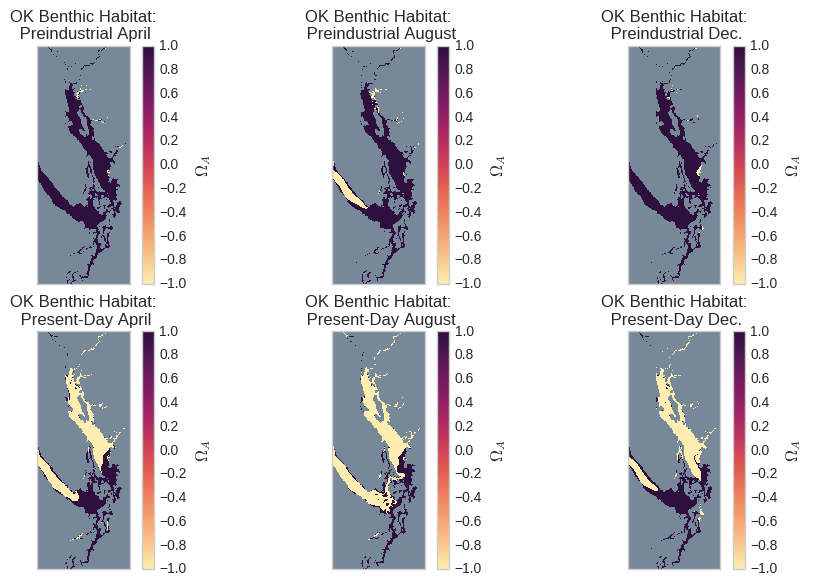

In [18]:
thres = 1

fact = 0.9
tf = 12
tcmap = cm.cm.matter
tvmin = -1
tvmax = 1

fig = plt.figure(figsize=(12*fact,7.5*fact))

ax = fig.add_subplot(2,3,1)
#tplt = np.ma.masked_values(PI_OmA_apr_benthos,0)
PI_OmA_apr_benthos_H = np.copy(PI_OmA_apr_benthos)
w = np.where((PI_OmA_apr_benthos>thres) & (PI_OmA_apr_benthos<1e19))
PI_OmA_apr_benthos_H[w]=1
w2 = np.where((PI_OmA_apr_benthos<thres))
PI_OmA_apr_benthos_H[w2]=-1
tplt = PI_OmA_apr_benthos_H
mesh = ax.pcolormesh(PI_OmA_apr_benthos_H, cmap=tcmap, vmin=tvmin, vmax=tvmax)
viz_tools.set_aspect(ax)
viz_tools.plot_land_mask(ax, \
                         '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'lightslategrey')
ax.set_title('OK Benthic Habitat:\n Preindustrial April', fontsize = tf)
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$', fontsize = tf)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(2,3,2)
PI_OmA_aug_benthos_H = np.copy(PI_OmA_aug_benthos)
w = np.where((PI_OmA_aug_benthos>thres) & (PI_OmA_aug_benthos<1e19))
PI_OmA_aug_benthos_H[w]=1
w2 = np.where((PI_OmA_aug_benthos<thres))
PI_OmA_aug_benthos_H[w2]=-1
tplt = PI_OmA_aug_benthos_H
mesh = ax.pcolormesh(PI_OmA_aug_benthos_H, cmap=tcmap, vmin=tvmin, vmax=tvmax)
viz_tools.set_aspect(ax)
viz_tools.plot_land_mask(ax, \
                         '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'lightslategrey')
ax.set_title('OK Benthic Habitat:\n Preindustrial August', fontsize = tf)
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$', fontsize = tf)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(2,3,3)
PI_OmA_dec_benthos_H = np.copy(PI_OmA_dec_benthos)
w = np.where((PI_OmA_dec_benthos>thres) & (PI_OmA_dec_benthos<1e19))
PI_OmA_dec_benthos_H[w]=1
w2 = np.where((PI_OmA_dec_benthos<thres))
PI_OmA_dec_benthos_H[w2]=-1
tplt = PI_OmA_dec_benthos_H
mesh = ax.pcolormesh(PI_OmA_dec_benthos_H, cmap=tcmap, vmin=tvmin, vmax=tvmax)
viz_tools.set_aspect(ax)
viz_tools.plot_land_mask(ax, \
                         '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'lightslategrey')
ax.set_title('OK Benthic Habitat:\n Preindustrial Dec.', fontsize = tf)
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$', fontsize = tf)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(2,3,4)
#tplt = np.ma.masked_values(BR_OmA_apr_benthos,0)
BR_OmA_apr_benthos_H = np.copy(BR_OmA_apr_benthos)
w = np.where((BR_OmA_apr_benthos>thres) & (BR_OmA_apr_benthos<1e19))
BR_OmA_apr_benthos_H[w]=1
w2 = np.where((BR_OmA_apr_benthos<thres))
BR_OmA_apr_benthos_H[w2]=-1
tplt = BR_OmA_apr_benthos_H
mesh = ax.pcolormesh(BR_OmA_apr_benthos_H, cmap=tcmap, vmin=tvmin, vmax=tvmax)
viz_tools.set_aspect(ax)
viz_tools.plot_land_mask(ax, \
                         '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'lightslategrey')
ax.set_title('OK Benthic Habitat:\n Present-Day April', fontsize = tf)
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$', fontsize = tf)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(2,3,5)
BR_OmA_aug_benthos_H = np.copy(BR_OmA_aug_benthos)
w = np.where((BR_OmA_aug_benthos>thres) & (BR_OmA_aug_benthos<1e19))
BR_OmA_aug_benthos_H[w]=1
w2 = np.where((BR_OmA_aug_benthos<thres))
BR_OmA_aug_benthos_H[w2]=-1
tplt = BR_OmA_aug_benthos_H
mesh = ax.pcolormesh(BR_OmA_aug_benthos_H, cmap=tcmap, vmin=tvmin, vmax=tvmax)
viz_tools.set_aspect(ax)
viz_tools.plot_land_mask(ax, \
                         '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'lightslategrey')
ax.set_title('OK Benthic Habitat:\n Present-Day August', fontsize = tf)
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$', fontsize = tf)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(2,3,6)
BR_OmA_dec_benthos_H = np.copy(BR_OmA_dec_benthos)
w = np.where((BR_OmA_dec_benthos>thres) & (BR_OmA_dec_benthos<1e19))
BR_OmA_dec_benthos_H[w]=1
w2 = np.where((BR_OmA_dec_benthos<thres))
BR_OmA_dec_benthos_H[w2]=-1
tplt = BR_OmA_dec_benthos_H
mesh = ax.pcolormesh(BR_OmA_dec_benthos_H, cmap=tcmap, vmin=tvmin, vmax=tvmax)
viz_tools.set_aspect(ax)
viz_tools.plot_land_mask(ax, \
                         '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'lightslategrey')
ax.set_title('OK Benthic Habitat:\n Present-Day Dec.', fontsize = tf)
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$', fontsize = tf)
plt.xticks([])
plt.yticks([])

PI_OmA_apr_benthos_H2 = np.zeros_like(PI_OmA_apr_benthos_H)
PI_OmA_aug_benthos_H2 = np.zeros_like(PI_OmA_aug_benthos_H)
PI_OmA_dec_benthos_H2 = np.zeros_like(PI_OmA_dec_benthos_H)
BR_OmA_apr_benthos_H2 = np.zeros_like(BR_OmA_apr_benthos_H)
BR_OmA_aug_benthos_H2 = np.zeros_like(BR_OmA_aug_benthos_H)
BR_OmA_dec_benthos_H2 = np.zeros_like(BR_OmA_dec_benthos_H)

PI_OmA_apr_benthos_H2[PI_OmA_apr_benthos_H==1]=1
PI_OmA_aug_benthos_H2[PI_OmA_aug_benthos_H==1]=1
PI_OmA_dec_benthos_H2[PI_OmA_dec_benthos_H==1]=1
BR_OmA_apr_benthos_H2[BR_OmA_apr_benthos_H==1]=1
BR_OmA_aug_benthos_H2[BR_OmA_aug_benthos_H==1]=1
BR_OmA_dec_benthos_H2[BR_OmA_dec_benthos_H==1]=1

print('Omega A threshold is: '+str(int(thres)))
print('In april, percent benthic habitat lost is:')
print(100*(np.sum(PI_OmA_apr_benthos_H2)\
           -np.sum(BR_OmA_apr_benthos_H2))/np.sum(PI_OmA_apr_benthos_H2))
print('In august, percent benthic habitat lost is:')
print(100*(np.sum(PI_OmA_aug_benthos_H2)\
           -np.sum(BR_OmA_aug_benthos_H2))/np.sum(PI_OmA_aug_benthos_H2))
print('In december, percent benthic habitat lost is:')
print(100*(np.sum(PI_OmA_dec_benthos_H2)\
           -np.sum(BR_OmA_dec_benthos_H2))/np.sum(PI_OmA_dec_benthos_H2))


## THRESHOLD FOR OMEGA A = 1.5

Omega A threshold is: 1
In april, percent benthic habitat lost is:
65.05841339117013
In august, percent benthic habitat lost is:
57.60019722476579
In december, percent benthic habitat lost is:
93.15958233988326


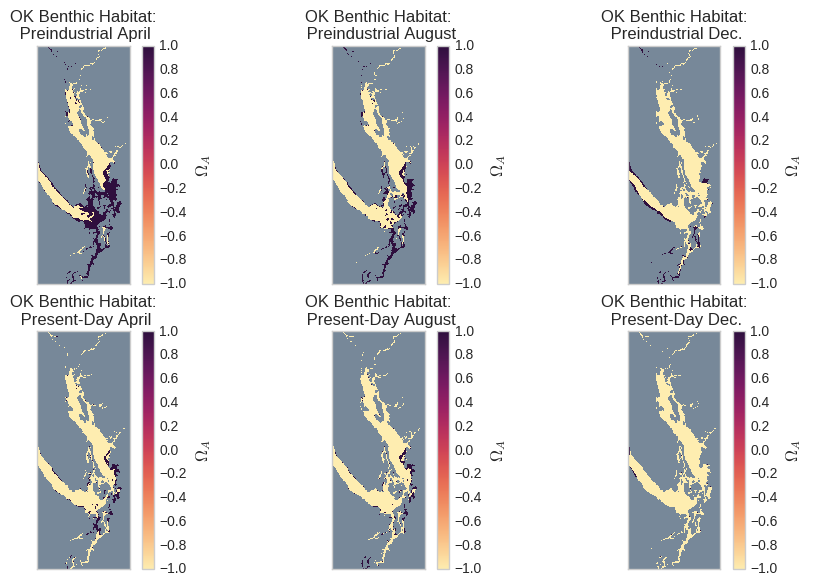

In [19]:
thres = 1.5

fact = 0.9
tf = 12
tcmap = cm.cm.matter
tvmin = -1
tvmax = 1

fig = plt.figure(figsize=(12*fact,7.5*fact))

ax = fig.add_subplot(2,3,1)
#tplt = np.ma.masked_values(PI_OmA_apr_benthos,0)
PI_OmA_apr_benthos_H = np.copy(PI_OmA_apr_benthos)
w = np.where((PI_OmA_apr_benthos>thres) & (PI_OmA_apr_benthos<1e19))
PI_OmA_apr_benthos_H[w]=1
w2 = np.where((PI_OmA_apr_benthos<thres))
PI_OmA_apr_benthos_H[w2]=-1
tplt = PI_OmA_apr_benthos_H
mesh = ax.pcolormesh(PI_OmA_apr_benthos_H, cmap=tcmap, vmin=tvmin, vmax=tvmax)
viz_tools.set_aspect(ax)
viz_tools.plot_land_mask(ax, \
                         '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'lightslategrey')
ax.set_title('OK Benthic Habitat:\n Preindustrial April', fontsize = tf)
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$', fontsize = tf)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(2,3,2)
PI_OmA_aug_benthos_H = np.copy(PI_OmA_aug_benthos)
w = np.where((PI_OmA_aug_benthos>thres) & (PI_OmA_aug_benthos<1e19))
PI_OmA_aug_benthos_H[w]=1
w2 = np.where((PI_OmA_aug_benthos<thres))
PI_OmA_aug_benthos_H[w2]=-1
tplt = PI_OmA_aug_benthos_H
mesh = ax.pcolormesh(PI_OmA_aug_benthos_H, cmap=tcmap, vmin=tvmin, vmax=tvmax)
viz_tools.set_aspect(ax)
viz_tools.plot_land_mask(ax, \
                         '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'lightslategrey')
ax.set_title('OK Benthic Habitat:\n Preindustrial August', fontsize = tf)
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$', fontsize = tf)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(2,3,3)
PI_OmA_dec_benthos_H = np.copy(PI_OmA_dec_benthos)
w = np.where((PI_OmA_dec_benthos>thres) & (PI_OmA_dec_benthos<1e19))
PI_OmA_dec_benthos_H[w]=1
w2 = np.where((PI_OmA_dec_benthos<thres))
PI_OmA_dec_benthos_H[w2]=-1
tplt = PI_OmA_dec_benthos_H
mesh = ax.pcolormesh(PI_OmA_dec_benthos_H, cmap=tcmap, vmin=tvmin, vmax=tvmax)
viz_tools.set_aspect(ax)
viz_tools.plot_land_mask(ax, \
                         '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'lightslategrey')
ax.set_title('OK Benthic Habitat:\n Preindustrial Dec.', fontsize = tf)
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$', fontsize = tf)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(2,3,4)
#tplt = np.ma.masked_values(BR_OmA_apr_benthos,0)
BR_OmA_apr_benthos_H = np.copy(BR_OmA_apr_benthos)
w = np.where((BR_OmA_apr_benthos>thres) & (BR_OmA_apr_benthos<1e19))
BR_OmA_apr_benthos_H[w]=1
w2 = np.where((BR_OmA_apr_benthos<thres))
BR_OmA_apr_benthos_H[w2]=-1
tplt = BR_OmA_apr_benthos_H
mesh = ax.pcolormesh(BR_OmA_apr_benthos_H, cmap=tcmap, vmin=tvmin, vmax=tvmax)
viz_tools.set_aspect(ax)
viz_tools.plot_land_mask(ax, \
                         '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'lightslategrey')
ax.set_title('OK Benthic Habitat:\n Present-Day April', fontsize = tf)
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$', fontsize = tf)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(2,3,5)
BR_OmA_aug_benthos_H = np.copy(BR_OmA_aug_benthos)
w = np.where((BR_OmA_aug_benthos>thres) & (BR_OmA_aug_benthos<1e19))
BR_OmA_aug_benthos_H[w]=1
w2 = np.where((BR_OmA_aug_benthos<thres))
BR_OmA_aug_benthos_H[w2]=-1
tplt = BR_OmA_aug_benthos_H
mesh = ax.pcolormesh(BR_OmA_aug_benthos_H, cmap=tcmap, vmin=tvmin, vmax=tvmax)
viz_tools.set_aspect(ax)
viz_tools.plot_land_mask(ax, \
                         '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'lightslategrey')
ax.set_title('OK Benthic Habitat:\n Present-Day August', fontsize = tf)
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$', fontsize = tf)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(2,3,6)
BR_OmA_dec_benthos_H = np.copy(BR_OmA_dec_benthos)
w = np.where((BR_OmA_dec_benthos>thres) & (BR_OmA_dec_benthos<1e19))
BR_OmA_dec_benthos_H[w]=1
w2 = np.where((BR_OmA_dec_benthos<thres))
BR_OmA_dec_benthos_H[w2]=-1
tplt = BR_OmA_dec_benthos_H
mesh = ax.pcolormesh(BR_OmA_dec_benthos_H, cmap=tcmap, vmin=tvmin, vmax=tvmax)
viz_tools.set_aspect(ax)
viz_tools.plot_land_mask(ax, \
                         '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'lightslategrey')
ax.set_title('OK Benthic Habitat:\n Present-Day Dec.', fontsize = tf)
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$', fontsize = tf)
plt.xticks([])
plt.yticks([])

PI_OmA_apr_benthos_H2 = np.zeros_like(PI_OmA_apr_benthos_H)
PI_OmA_aug_benthos_H2 = np.zeros_like(PI_OmA_aug_benthos_H)
PI_OmA_dec_benthos_H2 = np.zeros_like(PI_OmA_dec_benthos_H)
BR_OmA_apr_benthos_H2 = np.zeros_like(BR_OmA_apr_benthos_H)
BR_OmA_aug_benthos_H2 = np.zeros_like(BR_OmA_aug_benthos_H)
BR_OmA_dec_benthos_H2 = np.zeros_like(BR_OmA_dec_benthos_H)

PI_OmA_apr_benthos_H2[PI_OmA_apr_benthos_H==1]=1
PI_OmA_aug_benthos_H2[PI_OmA_aug_benthos_H==1]=1
PI_OmA_dec_benthos_H2[PI_OmA_dec_benthos_H==1]=1
BR_OmA_apr_benthos_H2[BR_OmA_apr_benthos_H==1]=1
BR_OmA_aug_benthos_H2[BR_OmA_aug_benthos_H==1]=1
BR_OmA_dec_benthos_H2[BR_OmA_dec_benthos_H==1]=1

print('Omega A threshold is: '+str(int(thres)))
print('In april, percent benthic habitat lost is:')
print(100*(np.sum(PI_OmA_apr_benthos_H2)\
           -np.sum(BR_OmA_apr_benthos_H2))/np.sum(PI_OmA_apr_benthos_H2))
print('In august, percent benthic habitat lost is:')
print(100*(np.sum(PI_OmA_aug_benthos_H2)\
           -np.sum(BR_OmA_aug_benthos_H2))/np.sum(PI_OmA_aug_benthos_H2))
print('In december, percent benthic habitat lost is:')
print(100*(np.sum(PI_OmA_dec_benthos_H2)\
           -np.sum(BR_OmA_dec_benthos_H2))/np.sum(PI_OmA_dec_benthos_H2))


## THRESHOLD = 0.5

Omega A threshold is: 0
In april, percent benthic habitat lost is:
0.05641579642299844
In august, percent benthic habitat lost is:
0.15709506049958627
In december, percent benthic habitat lost is:
0.15711955478794856


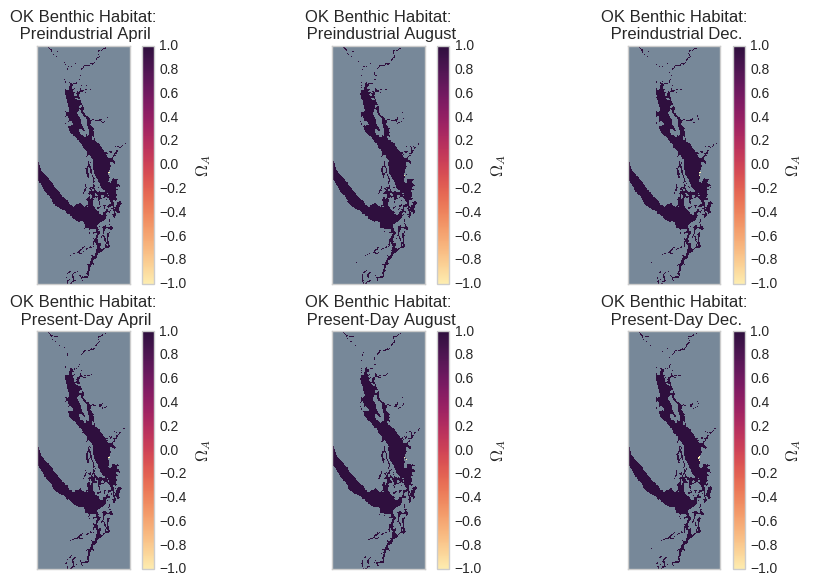

In [20]:
thres = 0.5

fact = 0.9
tf = 12
tcmap = cm.cm.matter
tvmin = -1
tvmax = 1

fig = plt.figure(figsize=(12*fact,7.5*fact))

ax = fig.add_subplot(2,3,1)
#tplt = np.ma.masked_values(PI_OmA_apr_benthos,0)
PI_OmA_apr_benthos_H = np.copy(PI_OmA_apr_benthos)
w = np.where((PI_OmA_apr_benthos>thres) & (PI_OmA_apr_benthos<1e19))
PI_OmA_apr_benthos_H[w]=1
w2 = np.where((PI_OmA_apr_benthos<thres))
PI_OmA_apr_benthos_H[w2]=-1
tplt = PI_OmA_apr_benthos_H
mesh = ax.pcolormesh(PI_OmA_apr_benthos_H, cmap=tcmap, vmin=tvmin, vmax=tvmax)
viz_tools.set_aspect(ax)
viz_tools.plot_land_mask(ax, \
                         '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'lightslategrey')
ax.set_title('OK Benthic Habitat:\n Preindustrial April', fontsize = tf)
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$', fontsize = tf)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(2,3,2)
PI_OmA_aug_benthos_H = np.copy(PI_OmA_aug_benthos)
w = np.where((PI_OmA_aug_benthos>thres) & (PI_OmA_aug_benthos<1e19))
PI_OmA_aug_benthos_H[w]=1
w2 = np.where((PI_OmA_aug_benthos<thres))
PI_OmA_aug_benthos_H[w2]=-1
tplt = PI_OmA_aug_benthos_H
mesh = ax.pcolormesh(PI_OmA_aug_benthos_H, cmap=tcmap, vmin=tvmin, vmax=tvmax)
viz_tools.set_aspect(ax)
viz_tools.plot_land_mask(ax, \
                         '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'lightslategrey')
ax.set_title('OK Benthic Habitat:\n Preindustrial August', fontsize = tf)
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$', fontsize = tf)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(2,3,3)
PI_OmA_dec_benthos_H = np.copy(PI_OmA_dec_benthos)
w = np.where((PI_OmA_dec_benthos>thres) & (PI_OmA_dec_benthos<1e19))
PI_OmA_dec_benthos_H[w]=1
w2 = np.where((PI_OmA_dec_benthos<thres))
PI_OmA_dec_benthos_H[w2]=-1
tplt = PI_OmA_dec_benthos_H
mesh = ax.pcolormesh(PI_OmA_dec_benthos_H, cmap=tcmap, vmin=tvmin, vmax=tvmax)
viz_tools.set_aspect(ax)
viz_tools.plot_land_mask(ax, \
                         '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'lightslategrey')
ax.set_title('OK Benthic Habitat:\n Preindustrial Dec.', fontsize = tf)
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$', fontsize = tf)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(2,3,4)
#tplt = np.ma.masked_values(BR_OmA_apr_benthos,0)
BR_OmA_apr_benthos_H = np.copy(BR_OmA_apr_benthos)
w = np.where((BR_OmA_apr_benthos>thres) & (BR_OmA_apr_benthos<1e19))
BR_OmA_apr_benthos_H[w]=1
w2 = np.where((BR_OmA_apr_benthos<thres))
BR_OmA_apr_benthos_H[w2]=-1
tplt = BR_OmA_apr_benthos_H
mesh = ax.pcolormesh(BR_OmA_apr_benthos_H, cmap=tcmap, vmin=tvmin, vmax=tvmax)
viz_tools.set_aspect(ax)
viz_tools.plot_land_mask(ax, \
                         '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'lightslategrey')
ax.set_title('OK Benthic Habitat:\n Present-Day April', fontsize = tf)
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$', fontsize = tf)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(2,3,5)
BR_OmA_aug_benthos_H = np.copy(BR_OmA_aug_benthos)
w = np.where((BR_OmA_aug_benthos>thres) & (BR_OmA_aug_benthos<1e19))
BR_OmA_aug_benthos_H[w]=1
w2 = np.where((BR_OmA_aug_benthos<thres))
BR_OmA_aug_benthos_H[w2]=-1
tplt = BR_OmA_aug_benthos_H
mesh = ax.pcolormesh(BR_OmA_aug_benthos_H, cmap=tcmap, vmin=tvmin, vmax=tvmax)
viz_tools.set_aspect(ax)
viz_tools.plot_land_mask(ax, \
                         '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'lightslategrey')
ax.set_title('OK Benthic Habitat:\n Present-Day August', fontsize = tf)
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$', fontsize = tf)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(2,3,6)
BR_OmA_dec_benthos_H = np.copy(BR_OmA_dec_benthos)
w = np.where((BR_OmA_dec_benthos>thres) & (BR_OmA_dec_benthos<1e19))
BR_OmA_dec_benthos_H[w]=1
w2 = np.where((BR_OmA_dec_benthos<thres))
BR_OmA_dec_benthos_H[w2]=-1
tplt = BR_OmA_dec_benthos_H
mesh = ax.pcolormesh(BR_OmA_dec_benthos_H, cmap=tcmap, vmin=tvmin, vmax=tvmax)
viz_tools.set_aspect(ax)
viz_tools.plot_land_mask(ax, \
                         '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'lightslategrey')
ax.set_title('OK Benthic Habitat:\n Present-Day Dec.', fontsize = tf)
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('$\Omega_A$', fontsize = tf)
plt.xticks([])
plt.yticks([])

PI_OmA_apr_benthos_H2 = np.zeros_like(PI_OmA_apr_benthos_H)
PI_OmA_aug_benthos_H2 = np.zeros_like(PI_OmA_aug_benthos_H)
PI_OmA_dec_benthos_H2 = np.zeros_like(PI_OmA_dec_benthos_H)
BR_OmA_apr_benthos_H2 = np.zeros_like(BR_OmA_apr_benthos_H)
BR_OmA_aug_benthos_H2 = np.zeros_like(BR_OmA_aug_benthos_H)
BR_OmA_dec_benthos_H2 = np.zeros_like(BR_OmA_dec_benthos_H)

PI_OmA_apr_benthos_H2[PI_OmA_apr_benthos_H==1]=1
PI_OmA_aug_benthos_H2[PI_OmA_aug_benthos_H==1]=1
PI_OmA_dec_benthos_H2[PI_OmA_dec_benthos_H==1]=1
BR_OmA_apr_benthos_H2[BR_OmA_apr_benthos_H==1]=1
BR_OmA_aug_benthos_H2[BR_OmA_aug_benthos_H==1]=1
BR_OmA_dec_benthos_H2[BR_OmA_dec_benthos_H==1]=1

print('Omega A threshold is: '+str(int(thres)))
print('In april, percent benthic habitat lost is:')
print(100*(np.sum(PI_OmA_apr_benthos_H2)\
           -np.sum(BR_OmA_apr_benthos_H2))/np.sum(PI_OmA_apr_benthos_H2))
print('In august, percent benthic habitat lost is:')
print(100*(np.sum(PI_OmA_aug_benthos_H2)\
           -np.sum(BR_OmA_aug_benthos_H2))/np.sum(PI_OmA_aug_benthos_H2))
print('In december, percent benthic habitat lost is:')
print(100*(np.sum(PI_OmA_dec_benthos_H2)\
           -np.sum(BR_OmA_dec_benthos_H2))/np.sum(PI_OmA_dec_benthos_H2))


In [21]:
BR_OmA_dec_benthos[0,0]
cell_counter = np.zeros_like(BR_OmA_dec_benthos)
cell_counter[BR_OmA_apr_benthos>1e10] =1
total_habitable_cells = 898*398 - np.sum(cell_counter)
print(total_habitable_cells)
print(np.sum(PI_OmA_apr_benthos_H2))

84042.0
83310.0


In [22]:
thresholds = np.arange(0,2.05,0.05)
BR_apr_hab = np.zeros_like(thresholds)
BR_aug_hab = np.zeros_like(thresholds)
BR_dec_hab = np.zeros_like(thresholds)
PI_apr_hab = np.zeros_like(thresholds)
PI_aug_hab = np.zeros_like(thresholds)
PI_dec_hab = np.zeros_like(thresholds)

In [23]:


for i in range(0,len(thresholds)):
    thres = thresholds[i]

    PI_OmA_apr_benthos_H = np.copy(PI_OmA_apr_benthos)
    w = np.where((PI_OmA_apr_benthos>thres) & (PI_OmA_apr_benthos<1e19))
    PI_OmA_apr_benthos_H[w]=1
    w2 = np.where((PI_OmA_apr_benthos<=thres))
    PI_OmA_apr_benthos_H[w2]=-1
    #
    PI_OmA_aug_benthos_H = np.copy(PI_OmA_aug_benthos)
    w = np.where((PI_OmA_aug_benthos>thres) & (PI_OmA_aug_benthos<1e19))
    PI_OmA_aug_benthos_H[w]=1
    w2 = np.where((PI_OmA_aug_benthos<=thres))
    PI_OmA_aug_benthos_H[w2]=-1
    #
    PI_OmA_dec_benthos_H = np.copy(PI_OmA_dec_benthos)
    w = np.where((PI_OmA_dec_benthos>thres) & (PI_OmA_dec_benthos<1e19))
    PI_OmA_dec_benthos_H[w]=1
    w2 = np.where((PI_OmA_dec_benthos<=thres))
    PI_OmA_dec_benthos_H[w2]=-1
    #
    BR_OmA_apr_benthos_H = np.copy(BR_OmA_apr_benthos)
    w = np.where((BR_OmA_apr_benthos>thres) & (BR_OmA_apr_benthos<1e19))
    BR_OmA_apr_benthos_H[w]=1
    w2 = np.where((BR_OmA_apr_benthos<=thres))
    BR_OmA_apr_benthos_H[w2]=-1
    #
    BR_OmA_aug_benthos_H = np.copy(BR_OmA_aug_benthos)
    w = np.where((BR_OmA_aug_benthos>thres) & (BR_OmA_aug_benthos<1e19))
    BR_OmA_aug_benthos_H[w]=1
    w2 = np.where((BR_OmA_aug_benthos<=thres))
    BR_OmA_aug_benthos_H[w2]=-1
    #
    BR_OmA_dec_benthos_H = np.copy(BR_OmA_dec_benthos)
    w = np.where((BR_OmA_dec_benthos>thres) & (BR_OmA_dec_benthos<1e19))
    BR_OmA_dec_benthos_H[w]=1
    w2 = np.where((BR_OmA_dec_benthos<=thres))
    BR_OmA_dec_benthos_H[w2]=-1
    #
    PI_OmA_apr_benthos_H2 = np.zeros_like(PI_OmA_apr_benthos_H)
    PI_OmA_aug_benthos_H2 = np.zeros_like(PI_OmA_aug_benthos_H)
    PI_OmA_dec_benthos_H2 = np.zeros_like(PI_OmA_dec_benthos_H)
    BR_OmA_apr_benthos_H2 = np.zeros_like(BR_OmA_apr_benthos_H)
    BR_OmA_aug_benthos_H2 = np.zeros_like(BR_OmA_aug_benthos_H)
    BR_OmA_dec_benthos_H2 = np.zeros_like(BR_OmA_dec_benthos_H)

    PI_OmA_apr_benthos_H2[PI_OmA_apr_benthos_H==1]=1
    PI_OmA_aug_benthos_H2[PI_OmA_aug_benthos_H==1]=1
    PI_OmA_dec_benthos_H2[PI_OmA_dec_benthos_H==1]=1
    BR_OmA_apr_benthos_H2[BR_OmA_apr_benthos_H==1]=1
    BR_OmA_aug_benthos_H2[BR_OmA_aug_benthos_H==1]=1
    BR_OmA_dec_benthos_H2[BR_OmA_dec_benthos_H==1]=1
    #print('*')
    #print('Omega A threshold is: '+str((thres)))
    #print('In april, percent benthic habitat lost is:')
    #print(100*(np.sum(PI_OmA_apr_benthos_H2)\
    #           -np.sum(BR_OmA_apr_benthos_H2))/np.sum(PI_OmA_apr_benthos_H2))
    BR_apr_hab[i] = np.sum(BR_OmA_apr_benthos_H2)
    PI_apr_hab[i] = np.sum(PI_OmA_apr_benthos_H2)
    
    #print('In august, percent benthic habitat lost is:')
    #print(100*(np.sum(PI_OmA_aug_benthos_H2)\
    #           -np.sum(BR_OmA_aug_benthos_H2))/np.sum(PI_OmA_aug_benthos_H2))
    BR_aug_hab[i] = np.sum(BR_OmA_aug_benthos_H2)
    PI_aug_hab[i] = np.sum(PI_OmA_aug_benthos_H2)
    #print('In december, percent benthic habitat lost is:')
    #print(100*(np.sum(PI_OmA_dec_benthos_H2)\
    #           -np.sum(BR_OmA_dec_benthos_H2))/np.sum(PI_OmA_dec_benthos_H2))
    BR_dec_hab[i] = np.sum(BR_OmA_dec_benthos_H2)
    PI_dec_hab[i] = np.sum(PI_OmA_dec_benthos_H2)

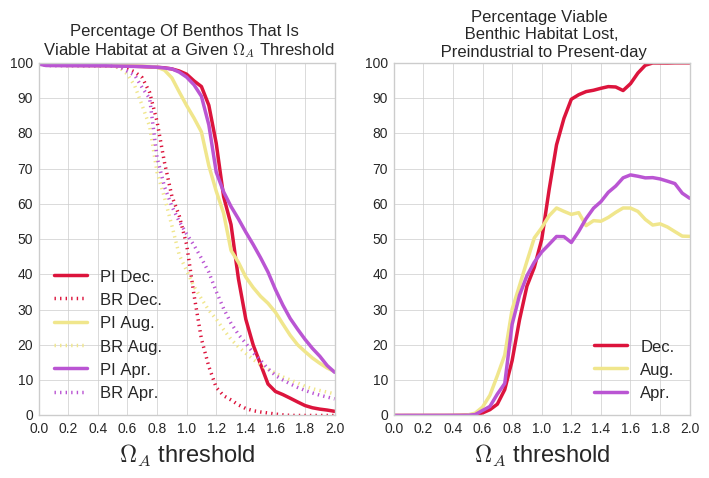

In [24]:
fact = 0.7
fig = plt.figure(figsize=(12*fact,6.5*fact))
lw = 2.5
ax = fig.add_subplot(1,2,1)
#tplt = np.ma.masked_values(PI_OmA_apr_benthos,0)
ax.plot(thresholds,100*(PI_dec_hab/total_habitable_cells),\
        color = 'crimson',linewidth = lw, label = 'PI Dec.')
ax.plot(thresholds,100*(BR_dec_hab/total_habitable_cells),\
        color = 'crimson', linestyle = ':', linewidth = lw, label = 'BR Dec.')
ax.plot(thresholds,100*(PI_aug_hab/total_habitable_cells),\
        color = 'khaki', linewidth = lw, label = 'PI Aug.')
ax.plot(thresholds,100*(BR_aug_hab/total_habitable_cells),\
        color = 'khaki', linestyle = ':', linewidth = lw, label = 'BR Aug.')
ax.plot(thresholds,100*(PI_apr_hab/total_habitable_cells),\
        color = 'mediumorchid', linewidth = lw, label = 'PI Apr.')
ax.plot(thresholds,100*(BR_apr_hab/total_habitable_cells),\
        color = 'mediumorchid', linestyle = ':', linewidth = lw, label = 'BR Apr.')
ax.legend(loc = 'lower left')
ax.set_xticks(np.arange(0, 2.2, step=0.2))
ax.set_yticks(np.arange(0, 110, step=10))
ax.set_xlabel('$\Omega_A$ threshold', fontsize = 17)
ax.set_title('Percentage Of Benthos That Is \n Viable Habitat at a Given $\Omega_A$ Threshold')

ax = fig.add_subplot(1,2,2)
#tplt = np.ma.masked_values(PI_OmA_apr_benthos,0)
ax.plot(thresholds,(100*(PI_dec_hab-BR_dec_hab)/PI_dec_hab),\
        color = 'crimson', linewidth = lw, label = 'Dec.')
ax.plot(thresholds,(100*(PI_aug_hab-BR_aug_hab)/PI_aug_hab),\
        color = 'khaki', linewidth = lw, label = 'Aug.')
ax.plot(thresholds,(100*(PI_apr_hab-BR_apr_hab)/PI_apr_hab),\
        color = 'mediumorchid', linewidth = lw, label = 'Apr.')
ax.set_title('')
ax.set_ylim(0,100)
ax.legend(loc = 'lower right')
ax.set_xticks(np.arange(0, 2.2, step=0.2))
ax.set_yticks(np.arange(0, 110, step=10))
ax.set_xlabel('$\Omega_A$ threshold', fontsize = 17)
ax.set_title('Percentage Viable \n Benthic Habitat Lost, \n Preindustrial to Present-day')

In [26]:

f = open('./new_pickle/PI_OmA_apr_mean.pkl', 'rb')
PI_OmA_apr_mean = pickle.load(f)   
f = open('./new_pickle/BR_OmA_apr_mean.pkl', 'rb')
BR_OmA_apr_mean = pickle.load(f)  

f = open('./new_pickle/PI_OmA_aug_mean.pkl', 'rb')
PI_OmA_aug_mean = pickle.load(f)  
f = open('./new_pickle/BR_OmA_dec_mean.pkl', 'rb')
BR_OmA_aug_mean = pickle.load(f)  

f = open('./new_pickle/PI_OmA_dec_mean.pkl', 'rb')
PI_OmA_dec_mean = pickle.load(f)
f = open('./new_pickle/BR_OmA_dec_mean.pkl', 'rb')
BR_OmA_dec_mean = pickle.load(f)
print('benthos...')
b = 27
print('PI')
print('apr')
print(PI_OmA_apr_mean[b,250:252,250:252])
print('aug')
print(PI_OmA_aug_mean[b,250:252,250:252])
print('dec')
print(PI_OmA_dec_mean[b,250:252,250:252])
print('')
print('BR')
print('apr')
print(BR_OmA_apr_mean[b,250:252,250:252])
print('aug')
print(BR_OmA_aug_mean[b,250:252,250:252])
print('dec')
print(BR_OmA_dec_mean[b,250:252,250:252])
print('')

b = 28
print('below benthos...')
print('PI')
print(PI_OmA_apr_mean[b,250:252,250:252])
print('')
print(PI_OmA_aug_mean[b,250:252,250:252])
print('')
print(PI_OmA_dec_mean[b,250:252,250:252])
print('')
print('BR')
print(BR_OmA_apr_mean[b,250:252,250:252])
print('')
print(BR_OmA_aug_mean[b,250:252,250:252])
print('')
print(BR_OmA_dec_mean[b,250:252,250:252])
print('')

benthos...
PI
apr
[[1.51667208 1.52062339]
 [1.51571349 1.52145277]]
aug
[[1.19508229 1.20087725]
 [1.19421202 1.20076496]]
dec
[[1.39048132 1.39102129]
 [1.3901835  1.3905737 ]]

BR
apr
[[1.12643601 1.13155554]
 [1.12552179 1.13234789]]
aug
[[1.05710249 1.05830494]
 [1.05689042 1.0576679 ]]
dec
[[1.05710249 1.05830494]
 [1.05689042 1.0576679 ]]

below benthos...
PI
[[1.e+20 1.e+20]
 [1.e+20 1.e+20]]

[[1.e+20 1.e+20]
 [1.e+20 1.e+20]]

[[1.e+20 1.e+20]
 [1.e+20 1.e+20]]

BR
[[1.e+20 1.e+20]
 [1.e+20 1.e+20]]

[[1.e+20 1.e+20]
 [1.e+20 1.e+20]]

[[1.e+20 1.e+20]
 [1.e+20 1.e+20]]

